# Extract all features using Res18 

In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def get_transform():
    return transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_pretrained_resnet18():
    model = resnet18(pretrained=True)
    model = nn.Sequential(*list(model.children())[:-1])
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return model.to(device)

def extract_patches_and_features(image, bboxes, model, transform):
    patches = []
    features = []

    for bbox in bboxes:
        # extract patch
        x_min, y_min, x_max, y_max = bbox
        patch = image[y_min:y_max, x_min:x_max]
        patch = Image.fromarray(patch)
        
        # preprocessing patch
        transformed_patch = transform(patch).unsqueeze(0).to(device)
        
        # extract feature
        with torch.no_grad():
            feature = model(transformed_patch).squeeze().cpu().numpy()
        
        patches.append(transformed_patch)
        features.append(feature)
    
    return patches, features

def load_yolo_annotations(annotation_file, image):
    bboxes = []
    with open(annotation_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            # only extract x_center, y_center, width, height
            x_center, y_center, width, height = map(float, parts[1:5])
            # normalized axis to absolute pixel axis
            img_width, img_height = image.shape[1], image.shape[0]
            x_min = int((x_center - width / 2) * img_width)
            y_min = int((y_center - height / 2) * img_width)
            x_max = int((x_center + width / 2) * img_width)
            y_max = int((y_center + height / 2) * img_width)
            bboxes.append([x_min, y_min, x_max, y_max])
    return bboxes

def unnormalize(img, mean, std):
    img = img * std[:, None, None] + mean[:, None, None]
    return img



In [ ]:
transform = get_transform()
model = get_pretrained_resnet18()

image_dir = '/Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/5_mixed/Det-dominik_v1-sf_v1.v2i.yolov8/train/images'
annotation_dir = '/Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/5_mixed/Det-dominik_v1-sf_v1.v2i.yolov8/train/labels'
output_dir = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search'

all_features = []
all_bboxes = []
all_image_names = []
all_patches = []

for image_file in os.listdir(image_dir):
    if image_file.endswith('.jpg') or image_file.endswith('.png'):
        # load image
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        
        # BGR -> RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # load annotations in YOLO format
        annotation_file = os.path.join(annotation_dir, os.path.splitext(image_file)[0] + '.txt')
        bboxes = load_yolo_annotations(annotation_file, image)

        # extract patches and features
        patches, features = extract_patches_and_features(image, bboxes, model, transform)
        
        # save patches
        all_patches.extend(patches)
        
        # save features and related information
        all_features.extend(features)
        all_bboxes.extend(bboxes)
        all_image_names.extend([image_file] * len(bboxes))

# randomly show 10 patches
if all_patches:
    num_patches_to_show = min(10, len(all_patches))
    random_indices = np.random.choice(len(all_patches), num_patches_to_show, replace=False)
    for random_index in random_indices:
        random_patch = all_patches[random_index].squeeze().cpu().numpy()
        
        # unnormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        random_patch = unnormalize(random_patch, mean, std)
        
        # limit the pixel in  [0, 1]
        random_patch = np.clip(random_patch, 0, 1)
        
        plt.imshow(np.transpose(random_patch, (1, 2, 0)))
        plt.title(f"Random Patch from Dataset")
        plt.show()

# save npz
all_features_np = np.array(all_features).astype('float32')
all_bboxes_np = np.array(all_bboxes)
all_image_names_np = np.array(all_image_names)
np.savez(output_dir + '/training_data.npz', features=all_features_np, bboxes=all_bboxes_np, image_names=all_image_names_np)


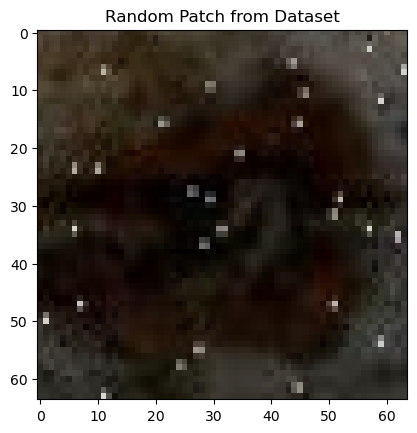

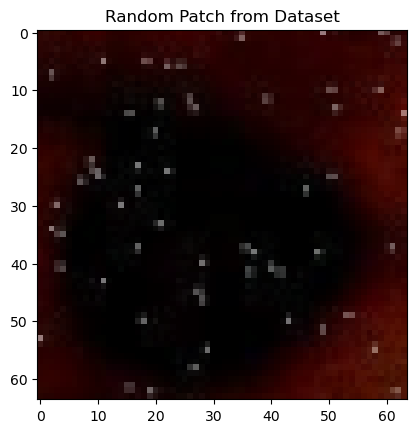

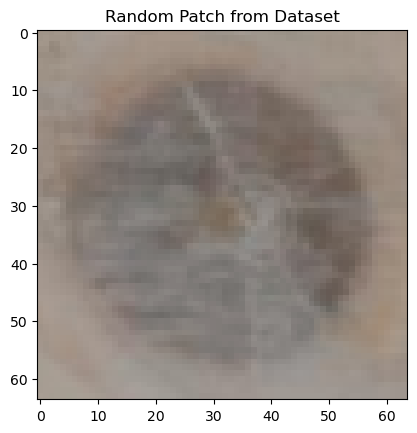

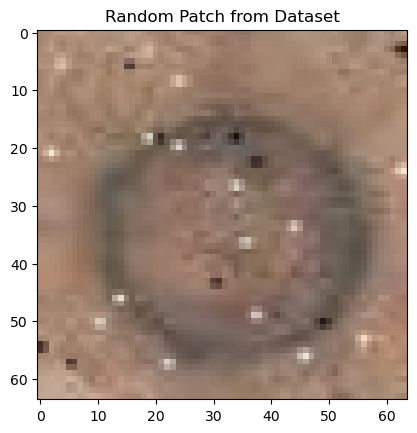

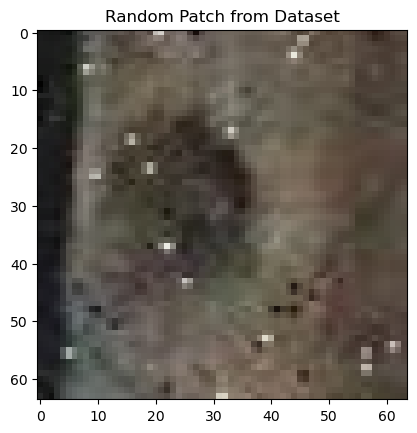

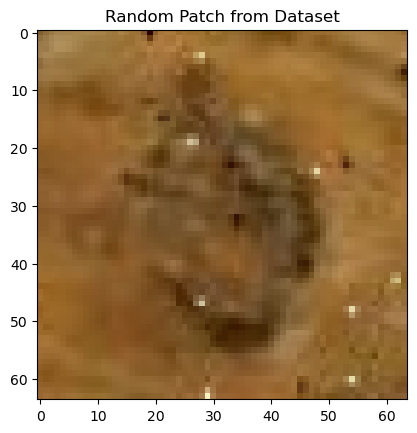

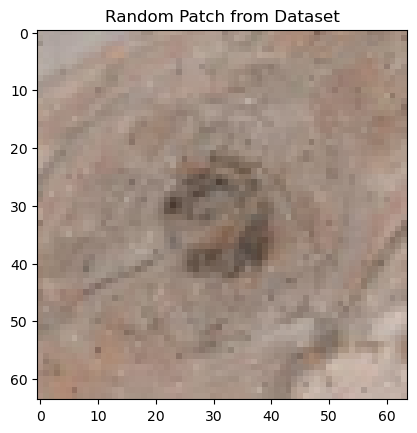

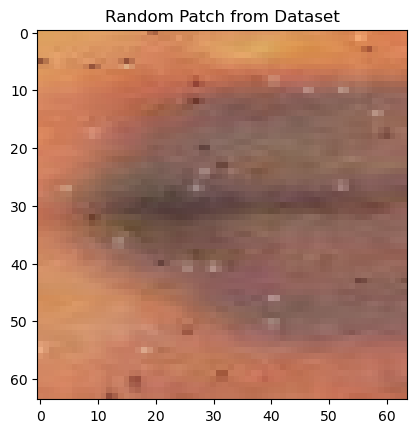

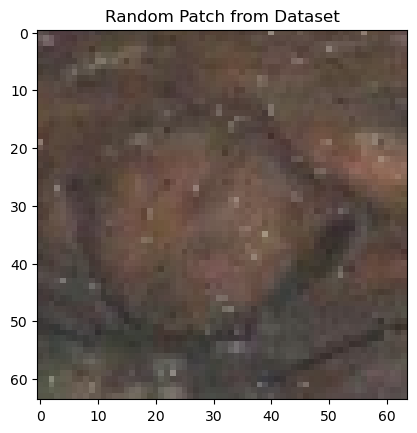

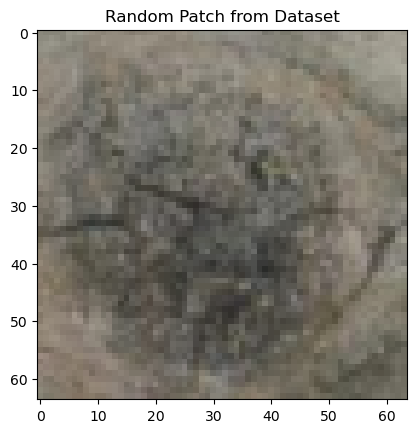

In [18]:
# randomly show 10 patches
if all_patches:
    num_patches_to_show = min(10, len(all_patches))
    random_indices = np.random.choice(len(all_patches), num_patches_to_show, replace=False)
    for random_index in random_indices:
        random_patch = all_patches[random_index].squeeze().cpu().numpy()
        
        # unnormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        random_patch = unnormalize(random_patch, mean, std)
        
        # limit the pixel in  [0, 1]
        random_patch = np.clip(random_patch, 0, 1)
        
        plt.imshow(np.transpose(random_patch, (1, 2, 0)))
        plt.title(f"Random Patch from Dataset")
        plt.show()


# kNN on target image with results

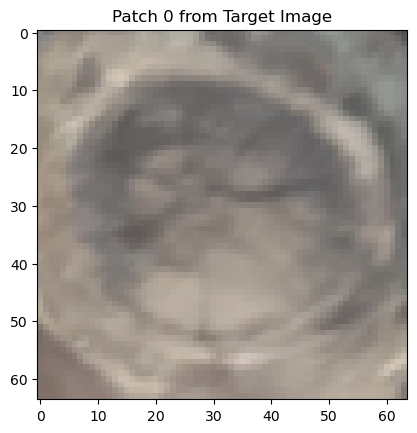

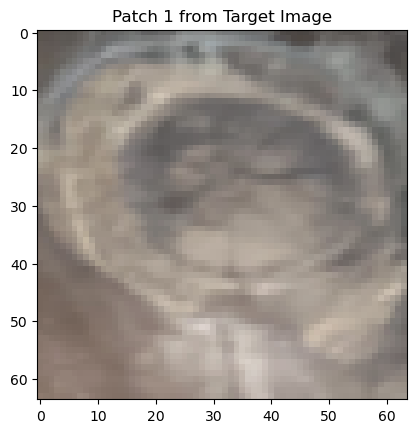

tf:  [array([7.40203738e-01, 0.00000000e+00, 8.46222341e-01, 2.27684784e+00,
       2.29171324e+00, 0.00000000e+00, 2.92883086e+00, 2.67626494e-02,
       1.02458680e+00, 2.32939273e-02, 2.12323260e+00, 1.93787837e+00,
       6.08503938e-01, 2.26679993e+00, 2.34060264e+00, 3.84493279e+00,
       0.00000000e+00, 0.00000000e+00, 1.48479033e+00, 9.84924287e-02,
       2.62325144e+00, 2.76578665e-01, 5.50591946e-01, 0.00000000e+00,
       2.13177228e+00, 1.88440502e-01, 1.80239737e+00, 3.72693706e+00,
       1.31689811e+00, 0.00000000e+00, 1.63264012e+00, 0.00000000e+00,
       2.96839190e+00, 1.11251879e+00, 0.00000000e+00, 2.66865993e+00,
       0.00000000e+00, 2.12890649e+00, 1.56597328e+00, 2.15026259e+00,
       0.00000000e+00, 1.68256497e+00, 0.00000000e+00, 2.89956760e+00,
       2.43291092e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.37515926e+00, 0.00000000e+00, 9.40387011e-01,
       2.00262547e+00, 1.59182763e+00, 0.00000000e+00, 0.00000000e+00,


In [72]:
import json
import cv2
import torch

def read_json(json_file):
    with open(json_file, 'r') as file:
        return json.load(file)


transform = get_transform()
model = get_pretrained_resnet18()

# #! image with 6 knots
# target_image = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/warped_M1_0244.jpeg'
# target_json = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/detected_warped_M1_0244.json'

#! image with overlapping knot
target_image = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/warped_M5_0064.jpeg'
target_json = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/detected_warped_M5_0064.json'

# #! image with metal
# target_image = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/warped_M2_0082.jpeg'
# target_json = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/detected_warped_M2_0082.json'

# #! image without knot
# target_image = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/warped_M6_0118.jpeg'
# target_json = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/test_knn/detected_warped_M6_0118.json'

knn_bank = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/kNN_knot.npz'

all_data = np.load(knn_bank)
all_features = all_data['features']
all_features_tensor = torch.tensor(all_features, dtype=torch.float32)


target_features = []
target_bboxes = []
target_ori_image = []
target_patches = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# read image and json
image = cv2.imread(target_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

json_data = read_json(target_json)

# extract bboxes
for box in json_data['boxes']:
    coordinates = (box['x1'], box['y1'], box['x2'], box['y2'])
    target_bboxes.append(coordinates)

# extract patches and features
patches, features = extract_patches_and_features(image, target_bboxes, model, transform)
target_patches.extend(patches)
target_features.extend(features)

if target_patches:
    num_patches_to_show = min(10, len(target_patches))  # 显示最多10个图像块
    for index in range(num_patches_to_show):
        patch = target_patches[index].squeeze().cpu().numpy()
        
        # unnormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        patch = unnormalize(patch, mean, std)
        
        # limit the pixel values to [0, 1]
        patch = np.clip(patch, 0, 1)
        
        plt.imshow(np.transpose(patch, (1, 2, 0)))
        plt.title(f"Patch {index} from Target Image")
        plt.show()


print("tf: ", target_features)
print("tb: ", target_bboxes)
print("tp: ", target_patches)

In [29]:
knn_bank = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Bias/kNN_search/kNN_knot.npz'

import numpy as np

data = np.load(knn_bank)

print("Keys in the npz file:", list(data.keys()))


Keys in the npz file: ['features', 'bboxes', 'image_names']


# use saved features to apply knn search within all_feature

## use Euclidean Distance

In [73]:
import numpy as np
import torch

class ed_kNN:
    def __init__(self, k):
        self.k = k
        self.X_train = None

    def fit(self, X_train):
        self.X_train = X_train

    def predict(self, X_test):
        distances = torch.cdist(X_test, self.X_train, p=2)
        knn_indices = distances.topk(self.k, dim=1, largest=False).indices
        return knn_indices
    
#! distance threshold
distance_threshold = 45

filtered_results = []

for index, target_feature in enumerate(target_features):
    target_feature = torch.tensor(target_feature, dtype=torch.float32).unsqueeze(0)
    
    # all_features_tensor = torch.nn.functional.normalize(all_features_tensor, p=2, dim=1)
    # target_feature = torch.nn.functional.normalize(target_feature, p=2, dim=1)

    # fit kNN model
    knn = ed_kNN(k=10)
    knn.fit(all_features_tensor)

    # predict neighbors
    predicted_neighbors = knn.predict(target_feature)
    
    # calculate distances
    distances = torch.cdist(target_feature, all_features_tensor[predicted_neighbors], p=2).squeeze()
    
    print(f"Target Feature Index: {index}, Min Distance: {distances.min().item()}")

    
    if distances.min().item() < distance_threshold:
        filtered_results.append({
            "target_index": index,
            "target_bbox": target_bboxes[index],
            "target_patch": target_patches[index],
            "predicted_neighbors": predicted_neighbors.cpu().numpy().tolist(),
            "min_distance": distances.min().item()
        })

for result in filtered_results:
    print(f"Target Feature Index: {result['target_index']}")
    print(f"Bounding Box: {result['target_bbox']}")
    print(f"Predicted Neighbors' Indices: {result['predicted_neighbors']}")
    print(f"Minimum Distance: {result['min_distance']}")


Target Feature Index: 0, Min Distance: 27.02718734741211
Target Feature Index: 1, Min Distance: 32.70198059082031
Target Feature Index: 0
Bounding Box: (1355, 1513, 1716, 1996)
Predicted Neighbors' Indices: [[4095, 3167, 935, 2107, 3221, 5006, 1592, 2257, 4790, 3866]]
Minimum Distance: 27.02718734741211
Target Feature Index: 1
Bounding Box: (1291, 1447, 1725, 2155)
Predicted Neighbors' Indices: [[2668, 1848, 3893, 4358, 2972, 619, 3844, 5031, 2756, 3784]]
Minimum Distance: 32.70198059082031


## use cosine

In [74]:
import torch

class cos_kNN:
    def __init__(self, k):
        self.k = k
        self.X_train = None

    def fit(self, X_train):
        self.X_train = X_train

    def predict(self, X_test):
        # Normalize both X_train and X_test -> unit vectors
        X_train_norm = torch.nn.functional.normalize(self.X_train, p=2, dim=1)
        X_test_norm = torch.nn.functional.normalize(X_test, p=2, dim=1)

        cosine_similarity = torch.matmul(X_test_norm, X_train_norm.T)
        cosine_distance = 1 - cosine_similarity

        knn_indices = cosine_distance.topk(self.k, dim=1, largest=False).indices
        return knn_indices

distance_threshold = 0.3

filtered_results = []

for index, target_feature in enumerate(target_features):
    target_feature = torch.tensor(target_feature, dtype=torch.float32).unsqueeze(0)
    
    # fit kNN model
    knn = cos_kNN(k=10)
    knn.fit(all_features_tensor)

    # predict neighbors
    predicted_neighbors = knn.predict(target_feature)
    
    # calculate cosine distance for the k nearest neighbors
    X_train_norm = torch.nn.functional.normalize(all_features_tensor[predicted_neighbors].squeeze(0), p=2, dim=1)
    X_test_norm = torch.nn.functional.normalize(target_feature, p=2, dim=1)

    # calculate cosine similarity using torch.nn.functional.cosine_similarity
    cosine_similarity = torch.nn.functional.cosine_similarity(X_test_norm, X_train_norm)
    cosine_distance = 1 - cosine_similarity

    print(f"Target Feature Index: {index}, Min Cosine Distance: {cosine_distance.min().item()}")

    if cosine_distance.min().item() < distance_threshold:
        filtered_results.append({
            "target_index": index,
            "target_bbox": target_bboxes[index],
            "target_patch": target_patches[index],
            "predicted_neighbors": predicted_neighbors.cpu().numpy().tolist(),
            "min_distance": cosine_distance.min().item()
        })

for result in filtered_results:
    print(f"Target Feature Index: {result['target_index']}")
    print(f"Bounding Box: {result['target_bbox']}")
    print(f"Predicted Neighbors' Indices: {result['predicted_neighbors']}")
    print(f"Minimum Cosine Distance: {result['min_distance']}")


Target Feature Index: 0, Min Cosine Distance: 0.16809386014938354
Target Feature Index: 1, Min Cosine Distance: 0.18960916996002197
Target Feature Index: 0
Bounding Box: (1355, 1513, 1716, 1996)
Predicted Neighbors' Indices: [[2563, 3739, 2107, 4095, 1592, 3221, 3167, 607, 935, 2214]]
Minimum Cosine Distance: 0.16809386014938354
Target Feature Index: 1
Bounding Box: (1291, 1447, 1725, 2155)
Predicted Neighbors' Indices: [[2668, 1848, 4634, 2667, 3197, 619, 3893, 4358, 3844, 2972]]
Minimum Cosine Distance: 0.18960916996002197
